# Установка зависимостей

In [1]:
!pip install catboost
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 671 kB/s 


# Загрузка необходимых библиотек

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostRegressor

from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *

pd.options.display.float_format = "{:.1f}".format
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight") 

# **Исследование данных**

##  **Первый взгляд на данные**

BHK: Количество комнат

Rent: Стоимость

Size: Площадь в м2

Floor: Этаж

Area Type: Способ подсчета площади жилья (Super Area or Carpet Area or Build Area)

Area Locality: Адрес

City: Город

Furnishing Status: Мебелировка (Furnished or Semi-Furnished or Unfurnished)

Tenant Preferred: Каких арендаторов предпочитает арендодатель

Bathroom: Количество ванных комнат

Point of Contact: Контакт для связи

In [4]:
data = pd.read_csv('/content/drive/MyDrive/HouseRegression/House_Rent_Dataset.csv')
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [5]:
def EDA(data):

    shape_info = data.shape

    print(f'\nКоличество строк: {shape_info[0]} \nКоличество столбцов:  {shape_info[1]}\n',
    '\n------------------------------------------------------------------------------------\n')

    print(f'Названия столбцов: {list(data.columns)}\n',
    '\n------------------------------------------------------------------------------------\n')

    print(f'Типы данных:\n')
    print(data.dtypes,
    '\n\n------------------------------------------------------------------------------------\n')

    print('Статистика для численных данных:\n')
    print(data.describe(),
    '\n\n------------------------------------------------------------------------------------\n')
    
    print('Количество уникальных значений для категориальных данных:\n')
    print(data[data.columns[(data.dtypes == object)]].apply(lambda x: x.nunique()),
    '\n\n------------------------------------------------------------------------------------\n')
    
    print('Пропущенные значения:\n')
    print(round(100 * (data.isnull().sum() / data.shape[0]), 2).apply(lambda x: str(x)+'%'),
    '\n\n------------------------------------------------------------------------------------\n')
    
EDA(data)


Количество строк: 4746 
Количество столбцов:  12
 
------------------------------------------------------------------------------------

Названия столбцов: ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
 
------------------------------------------------------------------------------------

Типы данных:

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object 

------------------------------------------------------------------------------------

Статистика для численных данных:

         BHK      Rent   Size  Bathroom
count 4746.0    4746.0 4746.0    4746.0
mean     2.1   34993.5  967.5   

## **Корреляция данных**

In [6]:
corr_matrix = data.corr()

heat_map_fig = px.imshow(corr_matrix, template="seaborn")

heat_map_fig.update_layout(xaxis_rangeslider_visible=False, 
                      autosize=False, 
                      width=500, 
                      height=500,
                      title={
                            'text': "Corellation of Numerical Variables"}
                    )


heat_map_fig.show()

In [7]:
data_corr = data.drop(['Posted On', 'Area Locality'], axis=1)

data_corr[['Floor', 'Area Type', 'City', 
           'Furnishing Status', 
           'Tenant Preferred', 
           'Point of Contact']] = data_corr[['Floor', 'Area Type', 'City', 
                                             'Furnishing Status', 'Tenant Preferred', 
                                             'Point of Contact']].apply(lambda x: pd.factorize(x)[0])

corr_matrix = data_corr.corr()

heat_map_fig = px.imshow(corr_matrix, template="seaborn")

heat_map_fig.update_layout(xaxis_rangeslider_visible=False, 
                      autosize=False, 
                      width=500, 
                      height=500,
                      title={
                            'text': "Corellation of Numerical Variables"}
                    )


heat_map_fig.show()

## **Визуализация категориальных признаков**

In [8]:
def create_bar_plot(data, column_name):
    
    sns.set_context("poster", font_scale = .8)
    plt.figure(figsize = (14, 6))
    plt.title(f'Количество данных по столбцу {column_name}')
    ax = data[column_name].value_counts().plot(kind = 'bar', color = "#2AB1F5", rot = 0)

    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() - 300),
                    ha = 'center',
                    va = 'bottom',
                    color = 'White')
        

def column_name_to_price(data, column_name):

    plt.figure(figsize=(14,6))
    plt.title(f'Зависимость стоимости аренды от {column_name}')
    fig = sns.lineplot(x=data[column_name], y=data['Rent'])

**Влияние города на цену аренды**

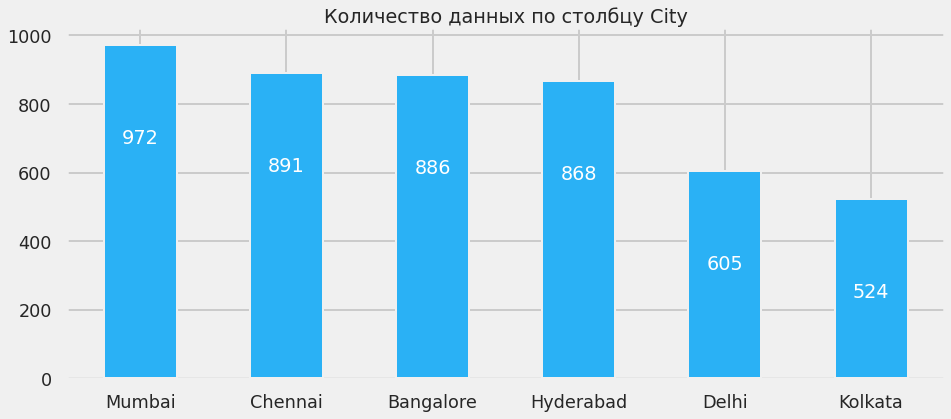

In [9]:
create_bar_plot(data, 'City')

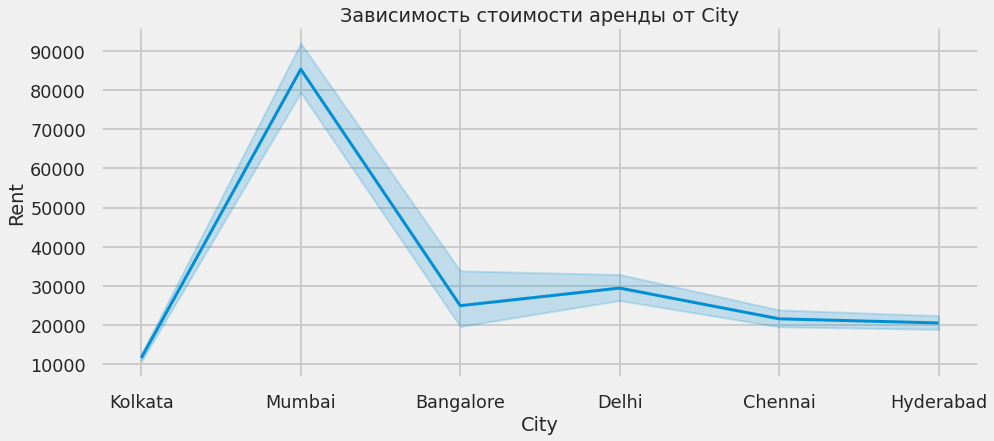

In [10]:
column_name_to_price(data, 'City')

**Влияние мебелировки на цену аренды**

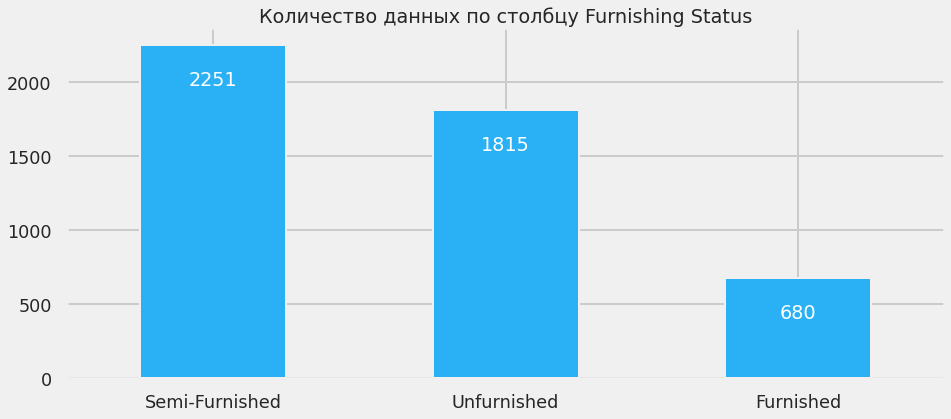

In [11]:
create_bar_plot(data, 'Furnishing Status')

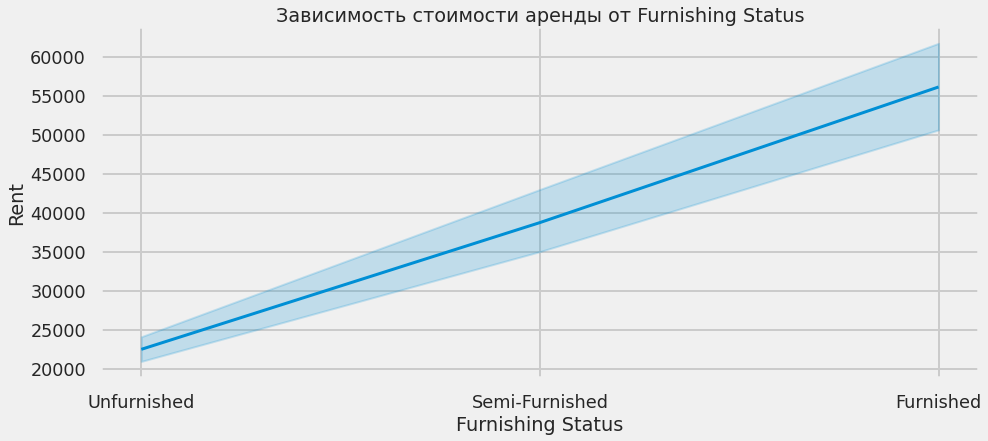

In [12]:
column_name_to_price(data, 'Furnishing Status')

**Влияние типа подсчета площади на цену аренды**

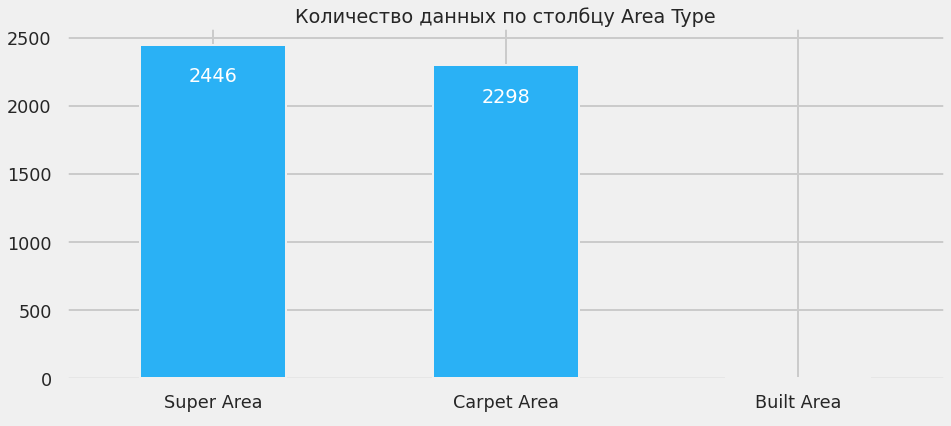

In [13]:
create_bar_plot(data, 'Area Type')

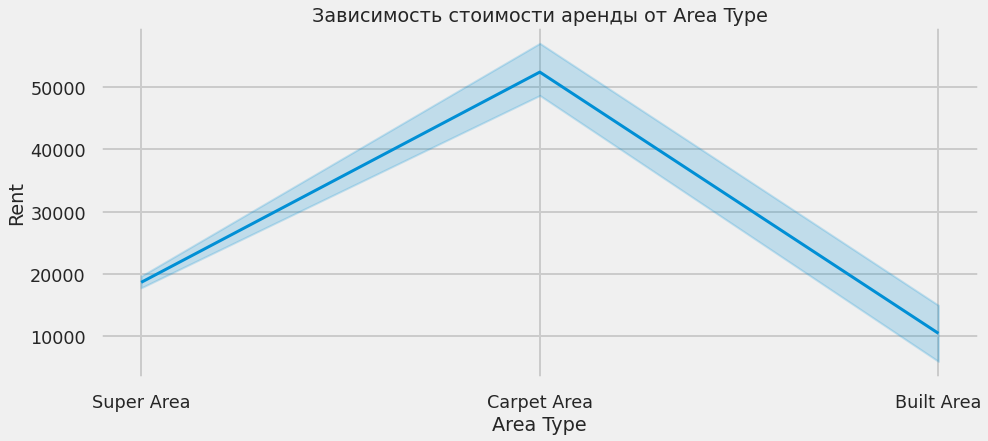

In [14]:
column_name_to_price(data, 'Area Type')

**Влияние метода аренды (через агента или нет) на цену аренды**

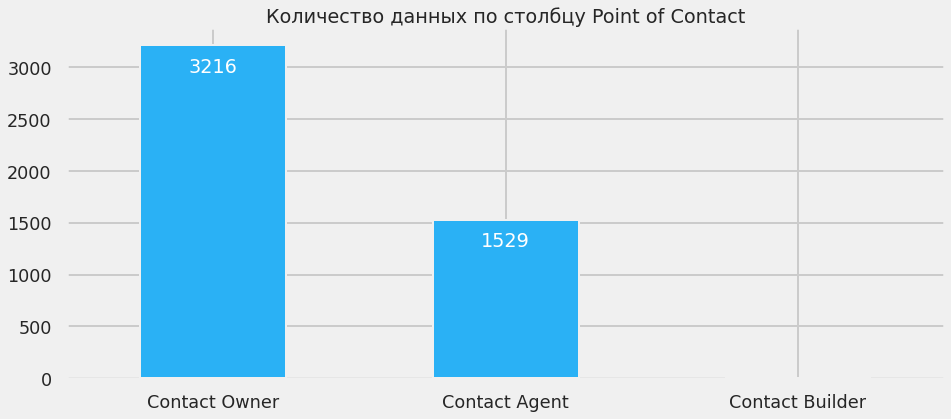

In [15]:
create_bar_plot(data, 'Point of Contact')

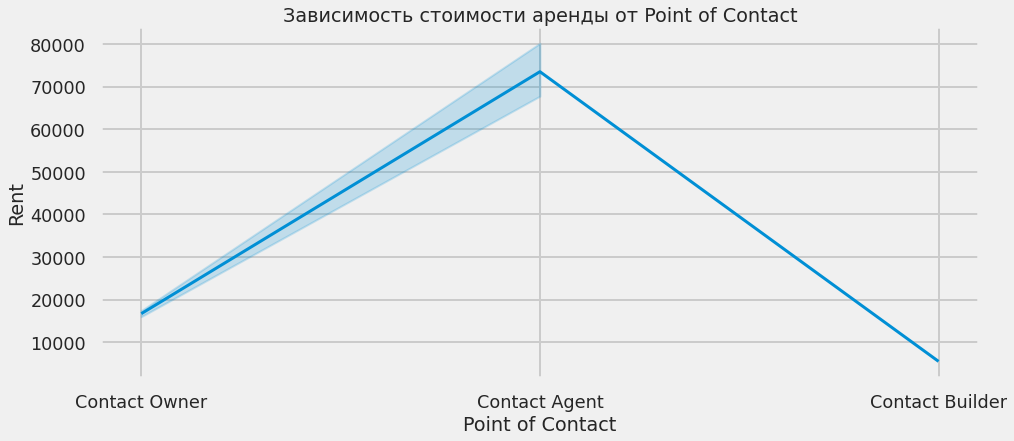

In [16]:
column_name_to_price(data, 'Point of Contact')

# **Предобработка данных**

**Преобразование признака времени**

In [17]:
data['Posted On'] = pd.to_datetime(data['Posted On'])

In [18]:
data['Posted On'].apply(lambda x: x.year).nunique()

1

In [19]:
data['month'] = data['Posted On'].apply(lambda x: x.month)
data['day'] = data['Posted On'].apply(lambda x: x.day)

# **Обработка категориальных признаков**

In [20]:
cat_features = ['Floor', 'Area Type', 'Area Locality', 
                'City', 'Furnishing Status',
                'Tenant Preferred', 'Point of Contact']
cat_features

['Floor',
 'Area Type',
 'Area Locality',
 'City',
 'Furnishing Status',
 'Tenant Preferred',
 'Point of Contact']

**Признак, которые можно бинаризировать**

In [21]:
print('Признак этажа до преобразования:')
print(data.Floor.sample(10).values)
print('Уникальных значения:', data.Floor.nunique())

print('\nПризнак этажа после преобразования:')
print(data.Floor.apply(lambda x: x.split(' out of')[0]).sample(10).values)
print('Уникальных значения:', data.Floor.apply(lambda x: x.split(' out of')[0]).nunique())

Признак этажа до преобразования:
['3 out of 3' 'Ground out of 3' '2 out of 7' '3 out of 30' '4 out of 7'
 '12 out of 25' '3 out of 3' '1 out of 2' 'Ground out of 1'
 'Ground out of 4']
Уникальных значения: 480

Признак этажа после преобразования:
['2' '2' 'Ground' '4' '1' '3' '1' '2' '1' '1']
Уникальных значения: 54


In [22]:
# Преобразование признака этажа
data.Floor = data.Floor.apply(lambda x: x.split(' out of')[0])

# Бинаризация категориальных признаков
data_categorical = pd.get_dummies(data[cat_features].drop(['Area Locality'], axis=1))

data_categorical.head()

,Floor_1,Floor_10,Floor_11,Floor_12,Floor_13,Floor_14,Floor_15,Floor_16,Floor_17,Floor_18,...,City_Mumbai,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


**Работа с признаком адреса**

In [23]:
vectorizer = TfidfVectorizer(max_features=100)
area_tfidf = vectorizer.fit_transform(data['Area Locality']).toarray()
print('Размер полученного датасета признаков:', area_tfidf.shape)

area_tfidf = pd.DataFrame(area_tfidf, columns=[f'tfidf_locality_{i}' for i in range(area_tfidf.shape[1])])

data_categorical = pd.concat([data_categorical, area_tfidf], axis=1)

data_categorical.head()

Размер полученного датасета признаков: (4746, 100)


,Floor_1,Floor_10,Floor_11,Floor_12,Floor_13,Floor_14,Floor_15,Floor_16,Floor_17,Floor_18,...,tfidf_locality_90,tfidf_locality_91,tfidf_locality_92,tfidf_locality_93,tfidf_locality_94,tfidf_locality_95,tfidf_locality_96,tfidf_locality_97,tfidf_locality_98,tfidf_locality_99
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Построение моделей**

## Анализ таргета

In [24]:
data.Rent.describe()

count      4746.0
mean      34993.5
std       78106.4
min        1200.0
25%       10000.0
50%       16000.0
75%       33000.0
max     3500000.0
Name: Rent, dtype: float64

## Подготовка данных для обучения

In [25]:
X = pd.concat([data.drop(cat_features, axis=1).drop(['Posted On', 'Rent'], axis=1),
               data_categorical], axis=1)

y = data['Rent']

In [26]:
# Разделяем данные на тренировочные, валидационные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=17)

## Линейная регрессия и случайный лес

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_val)
        
mae = round(mean_absolute_error(y_val, predictions), 3)
        
print(f'Linear Regression MAE: {mae}')

Linear Regression MAE: 18272276023.062


In [28]:
for n_estimators in [100, 125, 150]:
    for max_depth in [6, 8, 12, 16, 22, ]:

        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        
        mae = round(mean_absolute_error(y_val, predictions), 3)
        
        print(f'MAE: {mae}; n_estimators: {n_estimators}; max_depth: {max_depth}')

MAE: 13873.621; n_estimators: 100; max_depth: 6
MAE: 13374.65; n_estimators: 100; max_depth: 8
MAE: 13188.242; n_estimators: 100; max_depth: 12
MAE: 13549.086; n_estimators: 100; max_depth: 16
MAE: 13386.342; n_estimators: 100; max_depth: 22
MAE: 14275.998; n_estimators: 125; max_depth: 6
MAE: 13169.624; n_estimators: 125; max_depth: 8
MAE: 13167.823; n_estimators: 125; max_depth: 12
MAE: 12719.567; n_estimators: 125; max_depth: 16
MAE: 13412.152; n_estimators: 125; max_depth: 22
MAE: 14623.521; n_estimators: 150; max_depth: 6
MAE: 13275.348; n_estimators: 150; max_depth: 8
MAE: 12700.107; n_estimators: 150; max_depth: 12
MAE: 13323.633; n_estimators: 150; max_depth: 16
MAE: 12641.731; n_estimators: 150; max_depth: 22


## Модель градиентного бустинга - CatBoost

In [29]:
model = CatBoostRegressor(
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

predictions = model.predict(X_val)
mae = round(mean_absolute_error(y_val, predictions), 3)
        
print(f'CatBoost MAE: {mae}')

Learning rate set to 0.062906
0:	learn: 80095.7531007	test: 56005.6272164	best: 56005.6272164 (0)	total: 49.3ms	remaining: 49.3s
100:	learn: 36632.1430824	test: 27011.8689481	best: 27011.8689481 (100)	total: 309ms	remaining: 2.75s
200:	learn: 29241.3431680	test: 25301.2265368	best: 25301.2265368 (200)	total: 577ms	remaining: 2.29s
300:	learn: 23971.4892336	test: 23541.0710520	best: 23541.0710520 (300)	total: 815ms	remaining: 1.89s
400:	learn: 21428.6751931	test: 22456.8155555	best: 22456.8155555 (400)	total: 1.05s	remaining: 1.57s
500:	learn: 18749.4971962	test: 21715.9272186	best: 21675.6309511 (492)	total: 1.28s	remaining: 1.28s
600:	learn: 17025.0516119	test: 21361.9440875	best: 21346.8837075 (599)	total: 1.54s	remaining: 1.02s
700:	learn: 15873.8052214	test: 21104.1650250	best: 21092.6583272 (696)	total: 1.77s	remaining: 757ms
800:	learn: 14911.1689641	test: 21016.6130125	best: 21016.6130125 (800)	total: 2.02s	remaining: 503ms
900:	learn: 14055.6164885	test: 20833.3817878	best: 208

## TabNet

In [41]:
model = TabNetRegressor()
model.fit(X_train.values, y_train.values.reshape(-1, 1), eval_set=[(X_val.values, y_val.values.reshape(-1, 1))])

predictions = model.predict(X_val.values)
mae = round(mean_absolute_error(y_val, predictions), 3)
        
print(f'\nTabNet MAE: {mae}\n')

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cuda



epoch 0  | loss: 8772869546.66667| val_0_mse: 4532082897.82472|  0:00:00s
epoch 1  | loss: 8568751616.0| val_0_mse: 4532043114.6616|  0:00:00s
epoch 2  | loss: 9114095616.0| val_0_mse: 4531787627.78801|  0:00:00s
epoch 3  | loss: 9400192682.66667| val_0_mse: 4531213686.82132|  0:00:00s
epoch 4  | loss: 8766166357.33333| val_0_mse: 4530519238.79648|  0:00:00s
epoch 5  | loss: 8376930645.33333| val_0_mse: 4529626783.66406|  0:00:00s
epoch 6  | loss: 8902090752.0| val_0_mse: 4528040106.6448|  0:00:01s
epoch 7  | loss: 8472146602.66667| val_0_mse: 4525409461.55086|  0:00:01s
epoch 8  | loss: 8368041130.66667| val_0_mse: 4524014430.21538|  0:00:01s
epoch 9  | loss: 8488260096.0| val_0_mse: 4524652636.73936|  0:00:01s
epoch 10 | loss: 8758542762.66667| val_0_mse: 4525727789.1386|  0:00:01s
epoch 11 | loss: 8869559296.0| val_0_mse: 4521587365.49922|  0:00:01s
epoch 12 | loss: 9119853056.0| val_0_mse: 4518801027.57034|  0:00:02s
epoch 13 | loss: 9071964501.33333| val_0_mse: 4517042501.74185|  

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



## Переобучения лучшей модели и создание предсказаний

In [49]:
model = CatBoostRegressor(
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

final_preds = model.predict(X_test)

model_results = pd.DataFrame([y_test.values, final_preds])
model_results = model_results.transpose()
model_results = model_results.rename(columns={0:'Rent Price',1:'Predicted Rent Price'})

print('\n', model_results.describe())
print("\nMAE на тесто", round(mean_absolute_error(model_results['Rent Price'], model_results['Predicted Rent Price']), 1),'\n')

Learning rate set to 0.062906
0:	learn: 80095.7531007	test: 56005.6272164	best: 56005.6272164 (0)	total: 3.15ms	remaining: 3.15s
100:	learn: 36632.1430824	test: 27011.8689481	best: 27011.8689481 (100)	total: 248ms	remaining: 2.21s
200:	learn: 29241.3431680	test: 25301.2265368	best: 25301.2265368 (200)	total: 494ms	remaining: 1.96s
300:	learn: 23971.4892336	test: 23541.0710520	best: 23541.0710520 (300)	total: 757ms	remaining: 1.76s
400:	learn: 21428.6751931	test: 22456.8155555	best: 22456.8155555 (400)	total: 1.22s	remaining: 1.82s
500:	learn: 18749.4971962	test: 21715.9272186	best: 21675.6309511 (492)	total: 1.77s	remaining: 1.76s
600:	learn: 17025.0516119	test: 21361.9440875	best: 21346.8837075 (599)	total: 2.36s	remaining: 1.57s
700:	learn: 15873.8052214	test: 21104.1650250	best: 21092.6583272 (696)	total: 2.66s	remaining: 1.14s
800:	learn: 14911.1689641	test: 21016.6130125	best: 21016.6130125 (800)	total: 2.91s	remaining: 723ms
900:	learn: 14055.6164885	test: 20833.3817878	best: 208

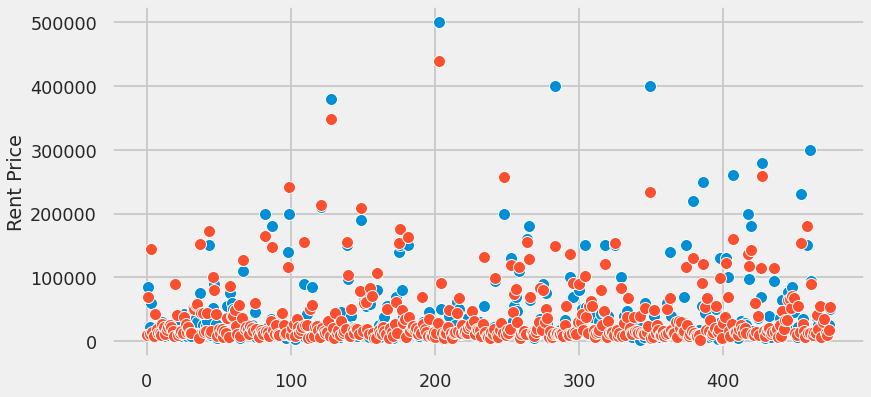

In [50]:
plt.figure(figsize= (12, 6))
sns.scatterplot(x=model_results.index.values, y=model_results['Rent Price'])
sns.scatterplot(x=model_results.index.values, y=model_results['Predicted Rent Price'])
plt.show()

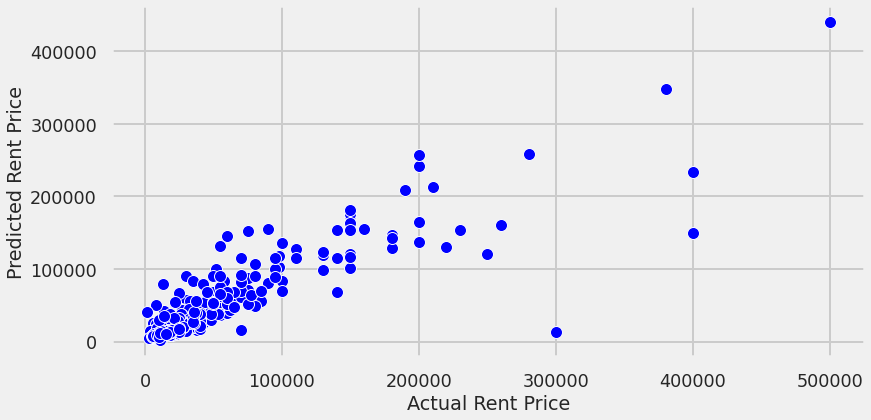

In [51]:
plt.figure(figsize= (12, 6))
sns.scatterplot(x= model_results['Rent Price'], y= model_results['Predicted Rent Price'], color= 'blue')
plt.xlabel('Actual Rent Price')
plt.ylabel('Predicted Rent Price')
plt.show()